# 12 - Quantum Random Access Optimization

In [1]:
# This code is from the tutorial at:
# https://qiskit-community.github.io/qiskit-optimization/tutorials/12_quantum_random_access_optimizer.html

# Set up a combinatorial optimization problem

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



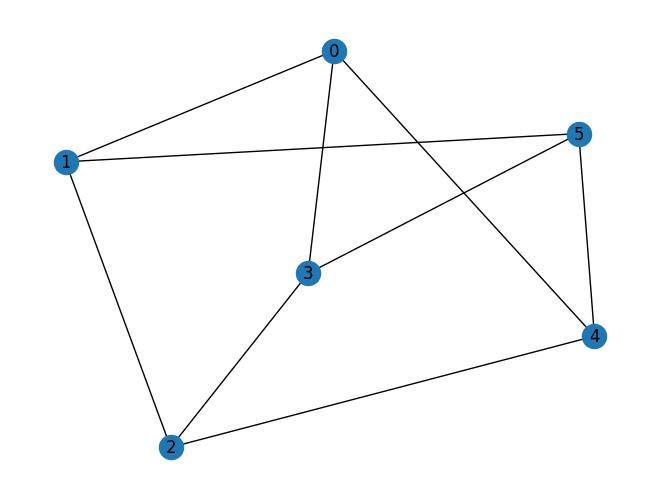

In [2]:
import networkx as nx

from qiskit_optimization.applications import Maxcut

seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

# Encode the problem into a quantum Hamiltonian

In [3]:
from qiskit_optimization.algorithms.qrao import QuantumRandomAccessEncoding


# Create an encoding object with a maximum of 3 variables per qubit, aka a (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)

# Encode the QUBO problem into an encoded Hamiltonian
encoding.encode(problem)

# This is our encoded Hamiltonian
print(f"Our encoded Hamiltonian is:\n( {encoding.qubit_op} ).\n")
print(
    "We achieve a compression ratio of "
    f"({encoding.num_vars} binary variables : {encoding.num_qubits} qubits) "
    f"≈ {encoding.compression_ratio}.\n"
)

Our encoded Hamiltonian is:
( SparsePauliOp(['XX', 'XY', 'XZ', 'YX', 'ZX', 'YY', 'YZ', 'ZY', 'ZZ'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j,
 1.5+0.j]) ).

We achieve a compression ratio of (6 binary variables : 2 qubits) ≈ 3.0.



# Solve the problem using the QuantumRandomAccessOptimizer

In [4]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes

# Switch to Quantum Rings's Estimator
#from qiskit.primitives import Estimator
from quantumrings.toolkit.qiskit import QrEstimatorV1 as Estimator

from qiskit_optimization.algorithms.qrao import (
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
)


# Prepare the VQE algorithm
ansatz = RealAmplitudes(2)
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=Estimator(),
)

# Use semi-deterministic rounding, known as "Pauli rounding"
# in https://arxiv.org/pdf/2111.03167v2.pdf
# (This is the default if no rounding scheme is specified.)
semidterministic_rounding = SemideterministicRounding()

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(min_eigen_solver=vqe, rounding_scheme=semidterministic_rounding)

In [5]:
# Solve the optimization problem
results = qrao.solve(problem)

print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

The objective function value: 6.0
x: [0 1 0 0 1 0]
relaxed function value: 8.999999971010112



The obtained solution places a partition between nodes [0, 2, 3, 5] and nodes [1, 4].


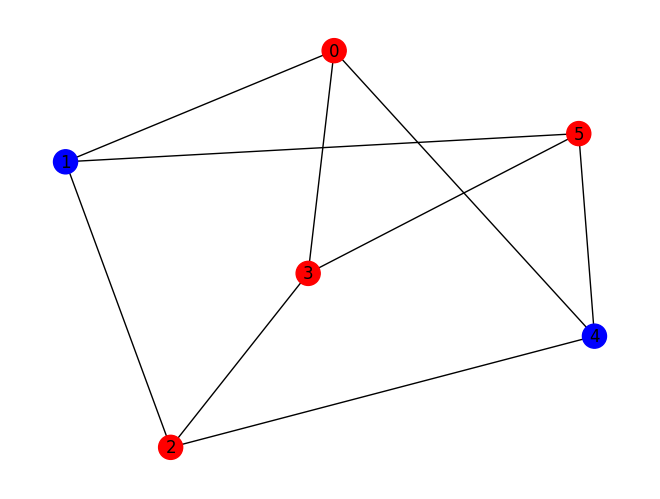

In [6]:
maxcut_partition = maxcut.interpret(results)
print(
    f"The obtained solution places a partition between nodes {maxcut_partition[0]} "
    f"and nodes {maxcut_partition[1]}."
)
maxcut.draw(results, pos=nx.spring_layout(graph, seed=seed))

# Inspect the results of subroutines

In [7]:
results.relaxed_result

In [8]:
results.samples

[SolutionSample(x=array([0, 1, 0, 0, 1, 0]), fval=np.float64(6.0), probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)]

# Exact Problem Solution with the NumpyMinimumEigensolver

In [9]:
from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_optimization.algorithms import MinimumEigenOptimizer

exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(problem)
print(exact_result.prettyprint())

objective function value: 9.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS


In [10]:
print("QRAO Approximate Optimal Function Value:", results.fval)
print("Exact Optimal Function Value:", exact_result.fval)
print(f"Approximation Ratio: {results.fval /  exact_result.fval :.2f}")

QRAO Approximate Optimal Function Value: 6.0
Exact Optimal Function Value: 9.0
Approximation Ratio: 0.67


# Solve the problem using the QuantumRandomAccessOptimizer with MagicRounding

In [11]:
# Switch to Quantum Rings's Sampler
#from qiskit.primitives import Sampler
from quantumrings.toolkit.qiskit import QrSamplerV1 as Sampler

from qiskit_optimization.algorithms.qrao import MagicRounding


estimator = Estimator(options={"shots": 1000, "seed": seed})
sampler = Sampler(options={"shots": 10000, "seed": seed})

# Prepare the VQE algorithm
ansatz = RealAmplitudes(2)
vqe = VQE(
    ansatz=ansatz,
    optimizer=COBYLA(),
    estimator=estimator,
)


# Use magic rounding
magic_rounding = MagicRounding(sampler=sampler)

# Construct the optimizer
qrao = QuantumRandomAccessOptimizer(min_eigen_solver=vqe, rounding_scheme=magic_rounding)

results = qrao.solve(problem)

In [12]:
print(
    f"The objective function value: {results.fval}\n"
    f"x: {results.x}\n"
    f"relaxed function value: {-1 * results.relaxed_fval}\n"
)

The objective function value: 9.0
x: [1 0 1 0 0 1]
relaxed function value: 8.999999973454623



In [13]:
print(f"The number of distinct samples is {len(results.samples)}.")
print("Top 10 samples with the largest fval:")
for sample in results.samples[:10]:
    print(sample)

The number of distinct samples is 56.
Top 10 samples with the largest fval:
SolutionSample(x=array([1, 0, 1, 0, 0, 1]), fval=np.float64(9.0), probability=np.float64(0.011), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0, 1, 0, 1, 1, 0]), fval=np.float64(9.0), probability=np.float64(0.0101), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0, 0, 0, 1, 1, 0]), fval=np.float64(6.0), probability=np.float64(0.0201), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1, 1, 1, 0, 0, 1]), fval=np.float64(6.0), probability=np.float64(0.0202), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0, 1, 1, 1, 1, 0]), fval=np.float64(6.0), probability=np.float64(0.0228), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1, 0, 0, 0, 0, 1]), fval=np.float64(6.0), probability=np.float64(0.0201), status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1, 0, 1, 0, 0, 0]), fval=np.float64(6

# Alternative: Solve the Problem in Two Explicit Steps

# Manually solve the relaxed problem.

In [14]:
# Encode the QUBO problem into a relaxed Hamiltonian
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

# Solve the relaxed problem
relaxed_results, rounding_context = qrao.solve_relaxed(encoding)

for k in dir(relaxed_results):
    if not k.startswith("_"):
        print(f"{k}: {getattr(relaxed_results, k)}")

aux_operators_evaluated: [(np.float64(-3.5907410051022604e-05), {'shots': 1000}), (np.float64(3.590226712997524e-05), {'shots': 1000}), (np.float64(0.0), {'shots': 1000}), (np.float64(0.0), {'shots': 1000}), (np.float64(7.497453856898303e-05), {'shots': 1000}), (np.float64(-7.497207561566258e-05), {'shots': 1000})]
combine: <bound method AlgorithmResult.combine of <qiskit_algorithms.minimum_eigensolvers.vqe.VQEResult object at 0x000001C865F5C750>>
cost_function_evals: 106
eigenvalue: -4.499999986614361
optimal_circuit:      ┌──────────────────────────────────────────────────────────┐
q_0: ┤0                                                         ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                         ├
     └──────────────────────────────────────────────────────────┘
optimal_parameters: {ParameterVectorElement(θ[0]): np.float64(0.6680825303089121), ParameterVectorElement(θ[1]): np.float64(-2.110460333534166), 

# Manually perform rounding on the relaxed problem results

In [15]:
# Round the relaxed solution using semi-deterministic rounding
semidterministic_rounding = SemideterministicRounding()
sdr_results = semidterministic_rounding.round(rounding_context)
qrao_results_sdr = qrao.process_result(
    problem=problem, encoding=encoding, relaxed_result=relaxed_results, rounding_result=sdr_results
)

print(
    f"The objective function value: {qrao_results_sdr.fval}\n"
    f"x: {qrao_results_sdr.x}\n"
    f"relaxed function value: {-1 * qrao_results_sdr.relaxed_fval}\n"
    f"The number of distinct samples is {len(qrao_results_sdr.samples)}."
)

The objective function value: 5.0
x: [1 0 0 1 0 1]
relaxed function value: -8.99999998661436
The number of distinct samples is 1.


In [16]:
magic_rounding = MagicRounding(sampler=sampler)
mr_results = magic_rounding.round(rounding_context)
qrao_results_mr = qrao.process_result(
    problem=problem, encoding=encoding, relaxed_result=relaxed_results, rounding_result=mr_results
)

print(
    f"The objective function value: {qrao_results_mr.fval}\n"
    f"x: {qrao_results_mr.x}\n"
    f"relaxed function value: {-1 * qrao_results_mr.relaxed_fval}\n"
    f"The number of distinct samples is {len(qrao_results_mr.samples)}."
)

The objective function value: 9.0
x: [1 0 1 0 0 1]
relaxed function value: -8.99999998661436
The number of distinct samples is 56.


# Appendix
# How to verify correctness of your encoding

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



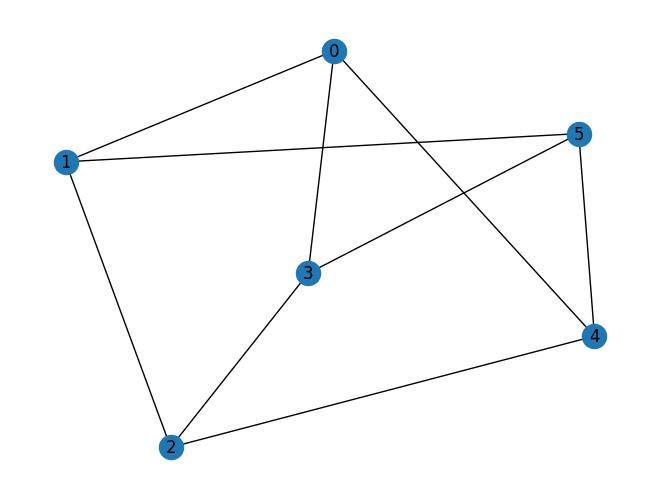

In [17]:
from qiskit_optimization.algorithms.qrao import EncodingCommutationVerifier

seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [18]:
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)

print("Encoded Problem:\n=================")
print(encoding.qubit_op)  # The Hamiltonian without the offset
print("Offset = ", encoding.offset)
print("Variables encoded on each qubit: ", encoding.q2vars)

Encoded Problem:
SparsePauliOp(['XX', 'XY', 'XZ', 'YX', 'ZX', 'YY', 'YZ', 'ZY', 'ZZ'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j,
 1.5+0.j])
Offset =  -4.5
Variables encoded on each qubit:  [[0, 2, 5], [1, 3, 4]]


In [19]:
import numpy as np

verifier = EncodingCommutationVerifier(encoding, estimator=Estimator())
if not len(verifier) == 2**encoding.num_vars:
    print("The number results of the encoded problem is not equal to 2 ** num_vars.")

for str_dvars, obj_val, encoded_obj_val in verifier:
    if not np.isclose(obj_val, encoded_obj_val):
        print(
            f"Violation identified: {str_dvars} evaluates to {obj_val} "
            f"but the encoded problem evaluates to {encoded_obj_val}."
        )